Implementation of Alexnet model on Keras:

In [43]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
# import metric
from keras.metrics import categorical_crossentropy
# optimization method 
from keras.optimizers import SGD
from Capsule_Keras import *

In [44]:
def Alexnet():
  # Initialize the model
  model = Sequential()

  # layer 1: convolutional layer + max-pooling layer
  model.add(Conv2D(filters = 96, kernel_size = (11,11), strides= 4, padding = 'valid', activation='relu', input_shape = (227,227,3)))
  model.add(MaxPooling2D(pool_size = (3,3), strides = 2))

  # layer 2: convolutional layer + max-pooling layer 
  model.add(Conv2D(filters = 256, kernel_size = (5,5), padding = 'same', activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (3,3), strides = 2))

  # layers 3-5: three convolutional layers + 1 max-pooling layer
  model.add(Conv2D(filters = 384, kernel_size = (3,3), padding = 'same', activation = 'relu'))
  model.add(Conv2D(filters = 384, kernel_size = (3,3), padding = 'same', activation = 'relu'))
  model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (3,3), strides = 2))

  # layers 6 - 8: two fully connected hidden layers and one fully connected output layer
  model.add(Flatten())
  model.add(Dense(4096, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(4096, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation = 'softmax'))

  # compile the model with a loss funciton, a metric and and optimizer method for estimating the loss function
  opt = SGD(lr = 0.1)
  model.compile(loss = categorical_crossentropy,
                optimizer = opt,
                metrics = ['accuracy'])

  return model

In [45]:
Alexnet_model = Alexnet()

c:\Users\Dr. Rajendra Ku Roul\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\legacy\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [46]:
Alexnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 27, 27, 96)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 27, 27, 256)       614656    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 13, 13, 256)      0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 13, 13, 384)       885120    
                                                                 
 conv2d_13 (Conv2D)          (None, 13, 13, 384)      

***This model has more than 62 millions parameters.***

In [47]:
import os
train_path = os.getcwd() + '/' + 'Dehazed_Images_3400/Dehazed_Images/train/' 
test_path = os.getcwd() + '/' + 'Dehazed_Images_3400/Dehazed_Images/test/'

In [48]:
print('The training set consists of ', len(os.listdir(train_path + 'busy/')), ' busy patches and ', len(os.listdir(train_path + 'free/')), ' Free patches.' )

The training set consists of  1900  busy patches and  1500  Free patches.


In [49]:
print('The test set consists of ', len(os.listdir(test_path + 'busy/')), ' busy patches and ', len(os.listdir(test_path + 'free/')), ' free patches.' )

The test set consists of  772  busy patches and  295  free patches.


Load images and labels 

In [51]:
cates = ['busy', 'free']
def load_images_and_labels(data_path, cates): 
  X = []
  y = []
  i = 0
  for index, cate in enumerate(cates): 
    for img_name in os.listdir(data_path + cate + '/'):
      i = i +1
      #print(i)
      img = cv2.imread(data_path + cate + '/' + img_name)
      if img is not None: 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_array = Image.fromarray(img, 'RGB')
        # resize image to 227x227 which is the required input size of the Alexnet model
        img_rs = img_array.resize((227,227))
        # convert the image to array
        img_rs = np.array(img_rs)
      
        X.append(img_rs)
        y.append(index)
  return X, y

Load the training data 

In [52]:
X_train, y_train = load_images_and_labels(train_path, cates)


In [ ]:

#print(y_train)
#Load the test set

In [53]:
X_test, y_test = load_images_and_labels(test_path, cates)

In [54]:
print('Training size: ', len(X_train), 'Testing size: ', len(X_test))

Training size:  3400 Testing size:  1067


Save X_train, y_train, X_test, y_test

In [55]:
data_dict = {'X_train' : X_train, 
             'y_train': y_train, 
             'X_test': X_test, 
             'y_test': y_test}
np.save('data_dict.npy', data_dict)

Load X_train, y_train, X_test, y_test

In [56]:
data_dict_ = np.load('data_dict.npy', allow_pickle = 'True').item()
X_train = data_dict_['X_train']
y_train = data_dict_['y_train']
X_test = data_dict_['X_test']
y_test = data_dict_['y_test']

#print(X_train,y_train)

Display randomly some images of the training set: 

In [57]:
import matplotlib.pyplot as plt
import random

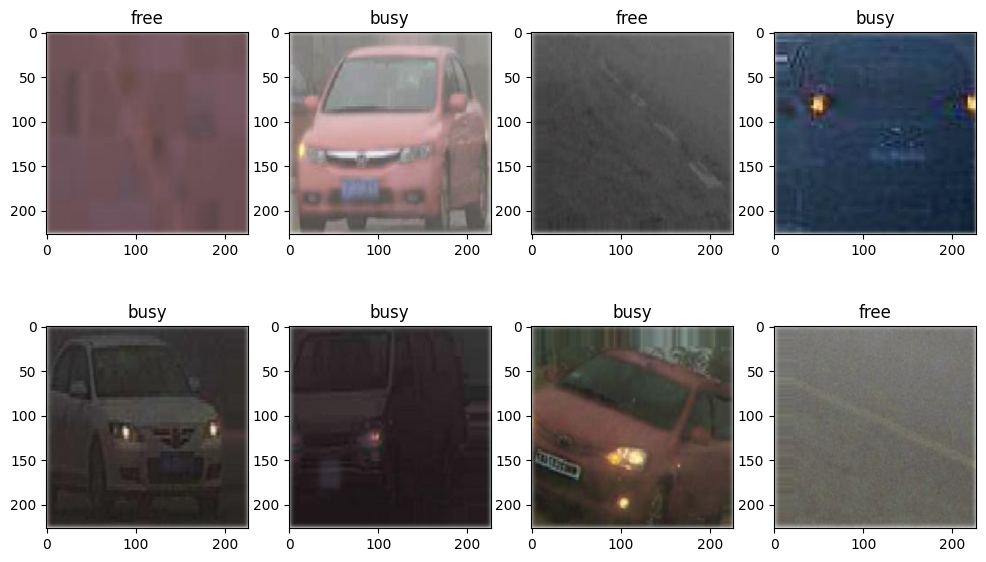

In [58]:
plt.figure(figsize = (12,7))
cate = ['busy', 'free']
for i in range(8):
  ind = random.randint(0, len(X_train))
  plt.subplot(240 + 1 + i)
  plt.imshow(X_train[ind])
  plt.title(cate[y_train[ind]])

### 2. Data preprocessing

This task consists of the following steps: 
- Convert integer values into floats
- Normalization
- One-hot encoding 

In [59]:
from keras.utils import to_categorical

In [60]:
def preprocess_data(X, y):
  # convert X from list to array
  X = np.array(X)
  
  # convert integer values of X into floats
  X = X.astype(np.float32)

  # normalization 
  X = X/255.0
  
  # one-hot encoding the labels 
  y = to_categorical(np.array(y))
    
  return X, y
(X_train, y_train) = preprocess_data(X_train, y_train)
(X_test, y_test) = preprocess_data(X_test, y_test)

Visualize some images of the training set after preprocessing: 

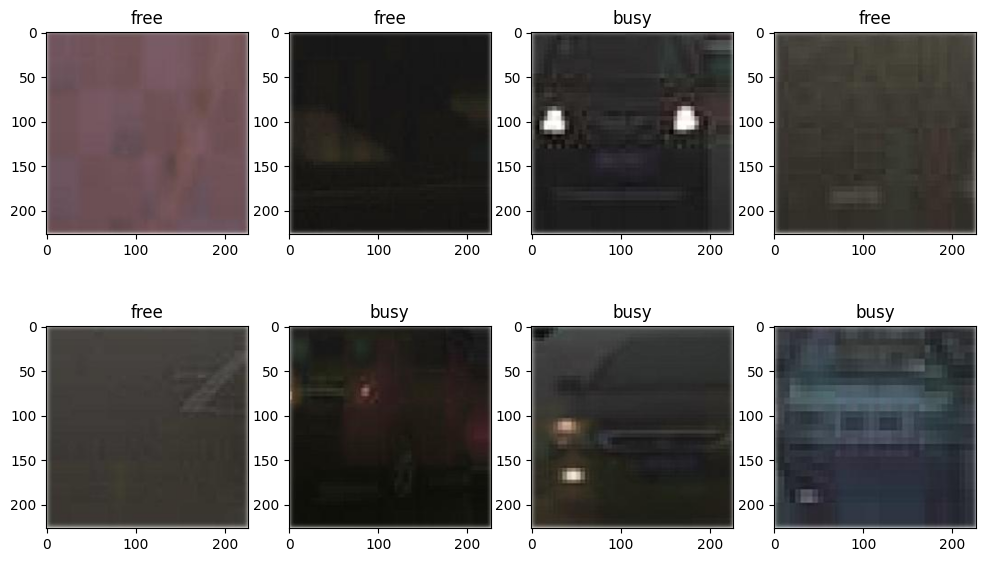

In [63]:
from matplotlib import pyplot as plt
import random
plt.figure(figsize = (12,7))
for i in range(8):
  ind = random.randint(0, len(X_train))
  plt.subplot(240 + 1 + i)
  plt.imshow(X_train[ind])
  plt.title(cate[np.argmax(y_train[ind])])